In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pymysql
from sqlalchemy import create_engine
import getpass


from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display="diagram")

In [2]:
password = getpass.getpass()

········


In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

Instructions
Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.
Read the data into a Pandas dataframe.
Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.
Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.
Create a logistic regression model to predict this variable from the cleaned data.
Evaluate the results.

## Project definition

In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

q = '''
SELECT f.*, c.name AS category_name, 
       q.times_rented_aug_2005, q2.times_rented_july_2005,
       q3.times_rented_june_2005, q4.times_rented_may_2005
  FROM film as f
  JOIN film_category AS fc
    ON fc.film_id = f.film_id
  JOIN category as c
    ON c.category_id = fc.category_id
  LEFT JOIN (SELECT f.film_id, COUNT(*) times_rented_aug_2005
		  FROM rental as r
		  JOIN inventory as i
			ON i.inventory_id = r.inventory_id
		  JOIN film as f
			ON f.film_id = i.film_id
		 WHERE SUBSTRING(r.rental_date, 1, 7) = "2005-08"
		 GROUP BY f.film_id) as q
	ON q.film_id = f.film_id
 LEFT JOIN (SELECT f.film_id, COUNT(*) times_rented_july_2005
		  FROM rental as r
		  JOIN inventory as i
			ON i.inventory_id = r.inventory_id
		  JOIN film as f
			ON f.film_id = i.film_id
		 WHERE SUBSTRING(r.rental_date, 1, 7) = "2005-07"
		 GROUP BY f.film_id) as q2
	ON q2.film_id = f.film_id
  LEFT JOIN (SELECT f.film_id, COUNT(*) times_rented_june_2005
		  FROM rental as r
		  JOIN inventory as i
			ON i.inventory_id = r.inventory_id
		  JOIN film as f
			ON f.film_id = i.film_id
		 WHERE SUBSTRING(r.rental_date, 1, 7) = "2005-06"
		 GROUP BY f.film_id) as q3
	ON q3.film_id = f.film_id
  LEFT JOIN (SELECT f.film_id, COUNT(*) times_rented_may_2005
		  FROM rental as r
		  JOIN inventory as i
			ON i.inventory_id = r.inventory_id
		  JOIN film as f
			ON f.film_id = i.film_id
		 WHERE SUBSTRING(r.rental_date, 1, 7) = "2005-05"
		 GROUP BY f.film_id) as q4
	ON q4.film_id = f.film_id;
'''

df = pd.read_sql_query(q, engine)

In [4]:
df.head(1)

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update,category_name,times_rented_aug_2005,times_rented_july_2005,times_rented_june_2005,times_rented_may_2005
0,19,AMADEUS HOLY,A Emotional Display of a Pioneer And a Technic...,2006,1,None,6,0.99,113,20.99,PG,"Commentaries,Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,Action,7.0,8.0,4.0,1.0


## Data Cleaning

In [5]:
df.isna().sum()

film_id                      0
title                        0
description                  0
release_year                 0
language_id                  0
original_language_id      1000
rental_duration              0
rental_rate                  0
length                       0
replacement_cost             0
rating                       0
special_features             0
last_update                  0
category_name                0
times_rented_aug_2005       42
times_rented_july_2005      42
times_rented_june_2005     100
times_rented_may_2005      314
dtype: int64

- Drop the original_language_id column
- replace all the nan values in columns times_rented_x with 0 since this will indicate that the respective movie was not rented during this month

In [6]:
df.drop('original_language_id', axis=1, inplace=True)

In [7]:
df['times_rented_aug_2005'].fillna(0, inplace=True)
df['times_rented_july_2005'].fillna(0, inplace=True)
df['times_rented_june_2005'].fillna(0, inplace=True)
df['times_rented_may_2005'].fillna(0, inplace=True)

In [8]:
df.isna().sum()

film_id                   0
title                     0
description               0
release_year              0
language_id               0
rental_duration           0
rental_rate               0
length                    0
replacement_cost          0
rating                    0
special_features          0
last_update               0
category_name             0
times_rented_aug_2005     0
times_rented_july_2005    0
times_rented_june_2005    0
times_rented_may_2005     0
dtype: int64

In [9]:
print(df.select_dtypes('object').apply(lambda col: col.unique()))

title               [AMADEUS HOLY, AMERICAN CIRCUS, ANTITRUST TOMA...
description         [A Emotional Display of a Pioneer And a Techni...
rating                                       [PG, R, NC-17, G, PG-13]
special_features    [Commentaries,Deleted Scenes,Behind the Scenes...
category_name       [Action, Animation, Children, Classics, Comedy...
dtype: object


In [10]:
print(df.select_dtypes('number').apply(lambda col: col.unique()))

film_id                   [19, 21, 29, 38, 56, 67, 97, 105, 111, 115, 12...
release_year                                                         [2006]
language_id                                                             [1]
rental_duration                                             [6, 3, 5, 7, 4]
rental_rate                                              [0.99, 4.99, 2.99]
length                    [113, 129, 168, 68, 77, 56, 125, 52, 167, 179,...
replacement_cost          [20.99, 17.99, 11.99, 25.99, 15.99, 24.99, 21....
times_rented_aug_2005     [7.0, 8.0, 2.0, 0.0, 6.0, 5.0, 11.0, 3.0, 9.0,...
times_rented_july_2005    [8.0, 4.0, 0.0, 11.0, 6.0, 7.0, 5.0, 9.0, 10.0...
times_rented_june_2005             [4.0, 3.0, 2.0, 0.0, 1.0, 5.0, 6.0, 7.0]
times_rented_may_2005                        [1.0, 2.0, 0.0, 3.0, 4.0, 5.0]
dtype: object


- drop release_year and language_id since they have only one value for all samples
- drop last_update column since no usefull info here
- set film_id as index

In [11]:
df.drop(['language_id', 'release_year', 'last_update'], axis=1, inplace=True)

In [12]:
df.select_dtypes('number').columns

Index(['film_id', 'rental_duration', 'rental_rate', 'length',
       'replacement_cost', 'times_rented_aug_2005', 'times_rented_july_2005',
       'times_rented_june_2005', 'times_rented_may_2005'],
      dtype='object')

In [13]:
df.set_index('film_id', inplace=True)
df.head(1)

,title,description,rental_duration,rental_rate,length,replacement_cost,rating,special_features,category_name,times_rented_aug_2005,times_rented_july_2005,times_rented_june_2005,times_rented_may_2005
film_id,,,,,,,,,,,,,
19,AMADEUS HOLY,A Emotional Display of a Pioneer And a Technic...,6,0.99,113,20.99,PG,"Commentaries,Deleted Scenes,Behind the Scenes",Action,7.0,8.0,4.0,1.0


## Prepare Target

In [14]:
# create one column which indicates if a movie was rented or not on aug 2005 
# -> this is the target that we want to predict
df['rented'] = [ np.minimum(1.0, val) for val in df['times_rented_aug_2005']]

aug_rented_backup = df['times_rented_aug_2005']

In [15]:
df['rented'].value_counts() / df.shape[0]

1.0    0.958
0.0    0.042
Name: rented, dtype: float64

- imbalance between positive and negative class

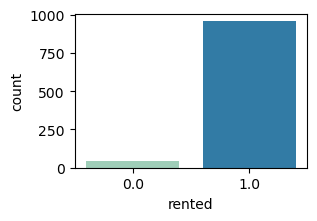

In [16]:
plt.figure(figsize=(3,2))
sns.countplot(x=df['rented'], palette='YlGnBu')
plt.show()

In [17]:
df.drop('times_rented_aug_2005', axis=1, inplace=True) # drop the col from which the target was extracted

## EDA

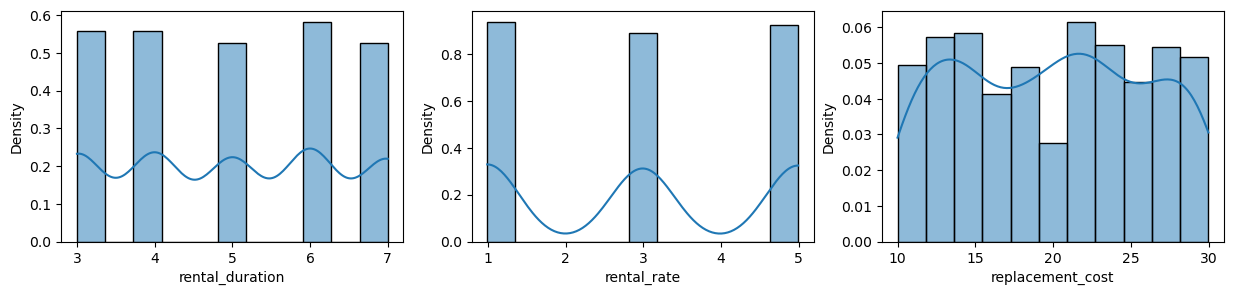

In [18]:
# check discrete nums:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
for i, col in enumerate(['rental_duration', 'rental_rate', 'replacement_cost']):
    sns.histplot(data=df[col], kde=True, stat='density', ax=ax[i])
plt.show()

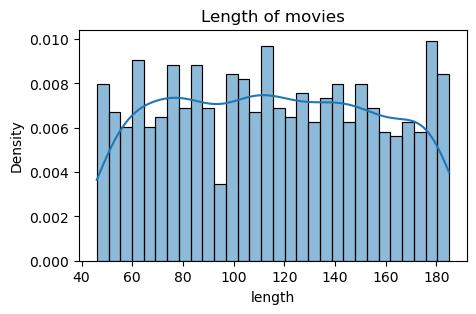

In [19]:
plt.figure(figsize=(5,3))
plt.title('Length of movies')
sns.histplot(data=df['length'], kde=True, stat='density', bins=30)
plt.show()

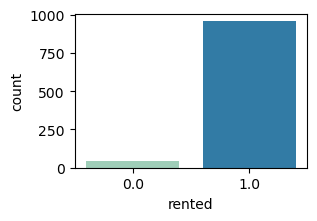

In [20]:
plt.figure(figsize=(3,2))
sns.countplot(x=df['rented'], palette='YlGnBu')
plt.show()

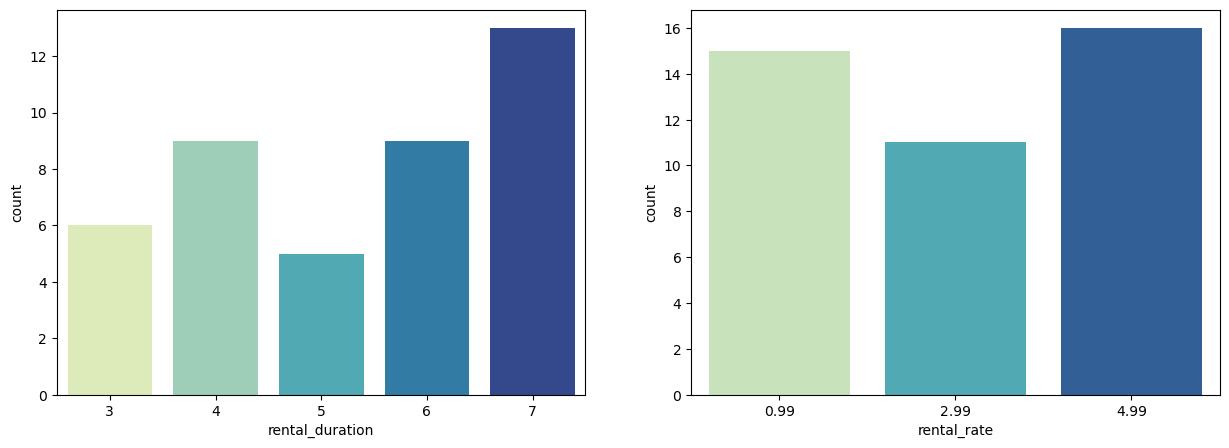

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i, col in enumerate(['rental_duration', 'rental_rate']):
    sns.countplot(x=df[df['rented'] == 0][col], ax=ax[i], palette='YlGnBu')
plt.show()

- no pattern recognizable yet

In [22]:
def categorize_length(v):
    if v < 60:
        return 'short'
    elif v < 120:
        return 'medium'
    elif v < 160:
        return 'long'
    elif v > 161:
        return 'very long'


df['length_category'] = [categorize_length(val) for val in df['length']]

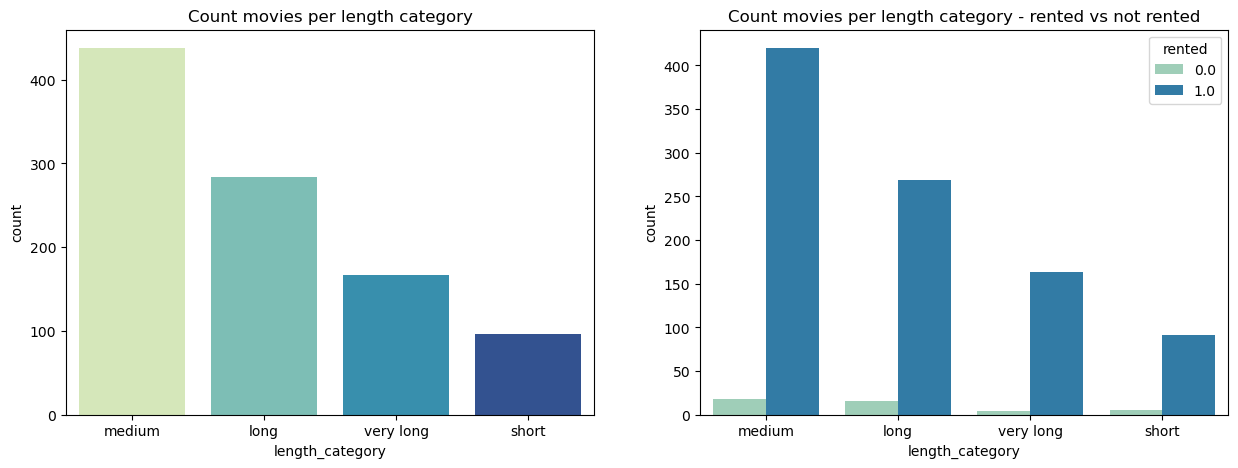

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x=df['length_category'], palette='YlGnBu', ax=ax[0])
ax[0].set_title('Count movies per length category')
sns.countplot(x=df['length_category'], hue=df['rented'], palette='YlGnBu', ax=ax[1])
ax[1].set_title('Count movies per length category - rented vs not rented')
plt.show()

In [24]:
df.drop('length_category', axis=1, inplace=True)

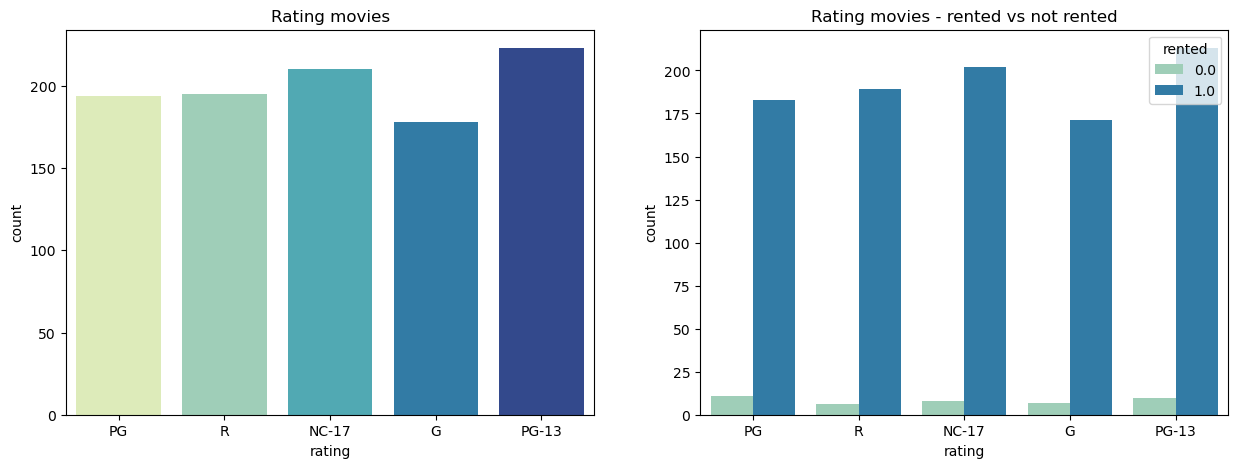

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x=df['rating'], palette='YlGnBu', ax=ax[0])
ax[0].set_title('Rating movies')
sns.countplot(x=df['rating'], hue=df['rented'], palette='YlGnBu', ax=ax[1])
ax[1].set_title('Rating movies - rented vs not rented')
plt.show()

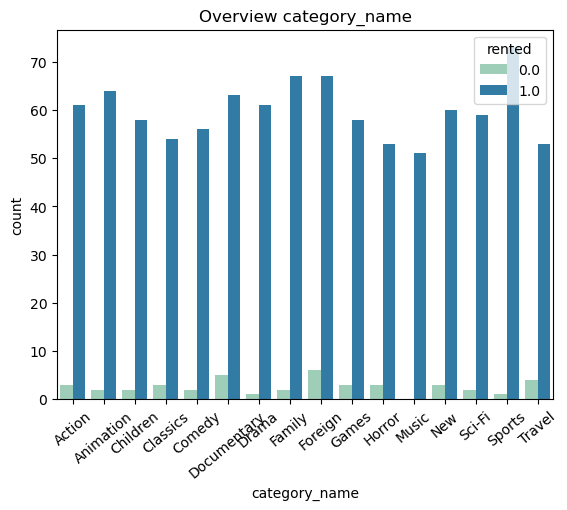

In [26]:
for cat in ['category_name']:
    sns.countplot(x=df[cat], hue=df['rented'], palette='YlGnBu')
    plt.xticks(rotation=40)
    plt.title(f'Overview {cat}')
    plt.show()

In [27]:
def extract_special_features():
    # extract set of special features
    special_features = set()
    for specials in df['special_features'].unique():
        [special_features.add(c) for c in specials.split(",")]

    # create new columns in df for every special feature and set to 0
    for feature in special_features:
        df[feature] = 0

    # extract special features per film and fill up the respective column with 1
    for i, row in df.iterrows():
        for f in row['special_features'].split(','):
            df.at[i, f] = 1

    # drop special_features initial column
    df.drop('special_features', axis=1, inplace=True)
    # clean headers
    df.columns = [col.lower().replace(' ', '_')for col in df.columns]

In [28]:
extract_special_features()

In [29]:
df.head(1)

,title,description,rental_duration,rental_rate,length,replacement_cost,rating,category_name,times_rented_july_2005,times_rented_june_2005,times_rented_may_2005,rented,trailers,deleted_scenes,commentaries,behind_the_scenes
film_id,,,,,,,,,,,,,,,,
19,AMADEUS HOLY,A Emotional Display of a Pioneer And a Technic...,6,0.99,113,20.99,PG,Action,8.0,4.0,1.0,1.0,0,1,1,1


- drop title and description for now

In [30]:
df.drop(['title', 'description'], axis=1, inplace=True)

In [31]:
df.head(1)

,rental_duration,rental_rate,length,replacement_cost,rating,category_name,times_rented_july_2005,times_rented_june_2005,times_rented_may_2005,rented,trailers,deleted_scenes,commentaries,behind_the_scenes
film_id,,,,,,,,,,,,,,
19,6,0.99,113,20.99,PG,Action,8.0,4.0,1.0,1.0,0,1,1,1


## Train and evaluate

In [32]:
data = df.copy()
y = data['rented']
X = data.drop('rented', axis=1, inplace=False)

In [33]:
def make_custom_pipeline(scaler, sampler, model, num_features, cat_features):
    return Pipeline([
            ('scaling', ColumnTransformer([
                ('numerical', scaler, num_features),
                ('categorical', OneHotEncoder(sparse=False), cat_features)
            ])),
            ('sampling', sampler),
            ('model', model)])

In [34]:
def display_confusion_matrix(y_pred, y, title, classes):
    cm = confusion_matrix(y, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(colorbar=False)
    disp.ax_.set_title(title)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92        29
         1.0       1.00      0.99      1.00       671

    accuracy                           0.99       700
   macro avg       0.93      1.00      0.96       700
weighted avg       0.99      0.99      0.99       700



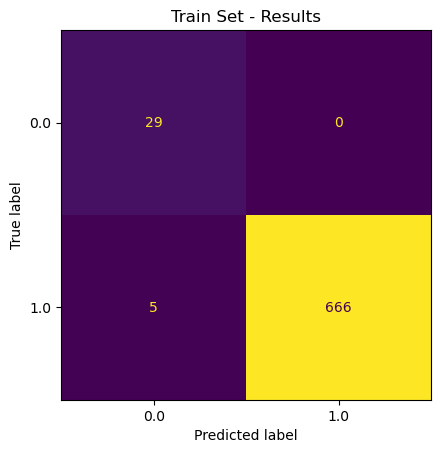

In [36]:
log_model = make_custom_pipeline(StandardScaler(), SMOTE(), LogisticRegression(), 
                                 X.select_dtypes('number').columns,
                                 X.select_dtypes('object').columns)

log_model.fit(X_train, y_train)

y_train_pred = log_model.predict(X_train)
y_test_pred = log_model.predict(X_test)

display_confusion_matrix(y_train_pred, y_train, 'Train Set - Results', log_model[2].classes_)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.76      1.00      0.87        13
         1.0       1.00      0.99      0.99       287

    accuracy                           0.99       300
   macro avg       0.88      0.99      0.93       300
weighted avg       0.99      0.99      0.99       300



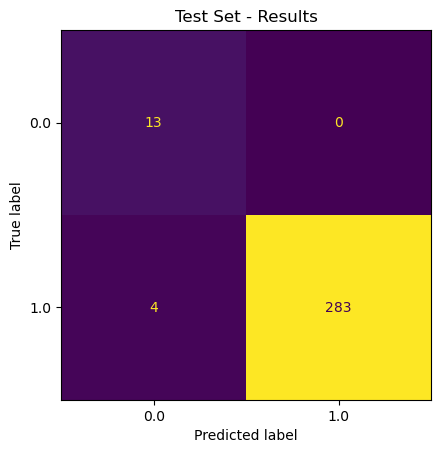

In [37]:
display_confusion_matrix(y_test_pred, y_test, 'Test Set - Results', log_model[2].classes_)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.51      1.00      0.67        29
         1.0       1.00      0.96      0.98       671

    accuracy                           0.96       700
   macro avg       0.75      0.98      0.83       700
weighted avg       0.98      0.96      0.97       700



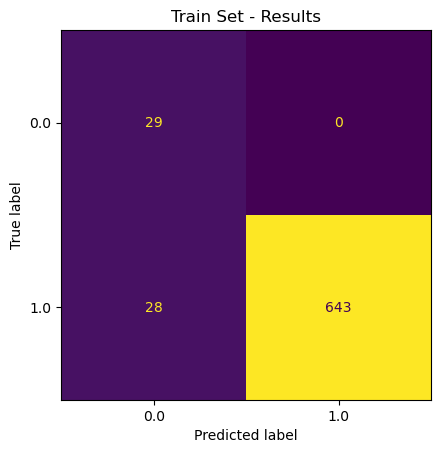

In [38]:
log_model_us = make_custom_pipeline(StandardScaler(), RandomUnderSampler(), LogisticRegression(), 
                                 X.select_dtypes('number').columns,
                                 X.select_dtypes('object').columns)

log_model_us.fit(X_train, y_train)

y_train_pred = log_model_us.predict(X_train)
y_test_pred = log_model_us.predict(X_test)

display_confusion_matrix(y_train_pred, y_train, 'Train Set - Results', log_model_us[2].classes_)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.65      1.00      0.79        13
         1.0       1.00      0.98      0.99       287

    accuracy                           0.98       300
   macro avg       0.82      0.99      0.89       300
weighted avg       0.98      0.98      0.98       300



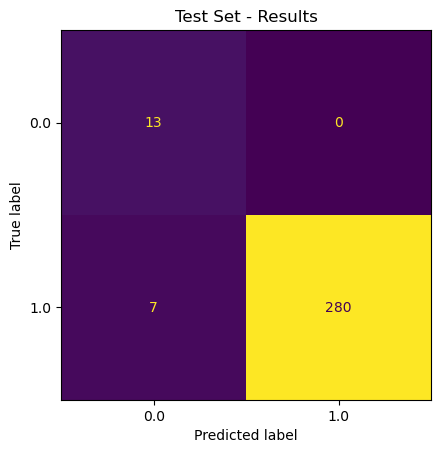

In [39]:
display_confusion_matrix(y_test_pred, y_test, 'Test Set - Results', log_model[2].classes_)
print(classification_report(y_test, y_test_pred))